# Neural Network

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [76]:
%run preprocessing.ipynb


In [77]:
# Perform preprocessing

data = perform_preprocessing() # type: ignore

C:\Users\robof\AppData\Local\Temp\ipykernel_12508\4038975902.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)


In [78]:
class NNModel(nn.Module):
    def __init__(self, seed, in_features=12, num_hidden_layers=4, out_categories=3):
        super(NNModel, self).__init__()
        self.num_hidden = num_hidden_layers
        hidden_layers = []
        for i in range(0,num_hidden_layers):
            hidden_layers.append(12)

        self.input = nn.Linear(in_features, hidden_layers[0])
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(hidden_layers[0], hidden_layers[1]))
        for i in range(1, num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
        self.output = nn.Linear(12, out_categories)

        np.random.seed(seed)
        torch.manual_seed(seed)
    def forward(self, x):
        x = F.relu(self.input(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = F.relu(self.output(x))
        return x

# Training the model

In [79]:
learning_rate = 0.05
epochs = 5000
seed = round(time.time())
num_hidden_layers = 2
test_proportion = 0.15

## Split the data

In [80]:
def split_data():
  X = data.drop(labels=['Type'], axis=1)
  y = data['Type']


  X = X.values
  y = y.values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_proportion, random_state = seed)

  X_train = torch.FloatTensor(X_train)
  X_test = torch.FloatTensor(X_test)

  y_train = torch.LongTensor(y_train)
  y_test = torch.LongTensor(y_test)
  
  return X_train, X_test, y_train, y_test


## Train model

### General setup

In [81]:
def calculate_metrics(matrix):    
    assert matrix.shape == (3, 3), "Matrix must be a 3x3 confusion matrix"

    accuracy = torch.trace(matrix) / torch.sum(matrix)

    true_positives = torch.diag(matrix)
    
    total_predicted_positives = torch.sum(matrix, dim=0)

    total_actual_positives = torch.sum(matrix, dim=1)

    precision = true_positives / total_predicted_positives
    precision[total_predicted_positives == 0] = 0

    recall = true_positives / total_actual_positives
    recall[total_actual_positives == 0] = 0

    f1 = torch.zeros_like(precision)
    nonzero_indices = (precision + recall > 0)
    f1[nonzero_indices] = 2 * precision[nonzero_indices] * recall[nonzero_indices] / (precision[nonzero_indices] + recall[nonzero_indices])
    
    precision = torch.mean(precision)
    recall = torch.mean(recall)
    f1 = torch.mean(f1)

    return accuracy, precision, recall, f1

In [82]:
def train_model(optimiser, criterion, epochs, classifier):
    losses = []
    X_train, X_test, y_train, y_test = split_data()
    
    for i in range(epochs):
        # shuffle training set
        num_instances = X_train.shape[0]
        indices = torch.randperm(num_instances)
        X_train = X_train[indices]
        y_train = y_train[indices]

        y_pred = classifier.forward(X_train)

        loss = criterion(y_pred, y_train)
        losses.append(loss.detach().numpy())

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    with torch.no_grad():        
        # Confusion matrix
        y_val = classifier.forward(X_train)
        loss = criterion(y_val, y_train)
        y_val = torch.argmax(y_val, dim=1)
        confusion_matrix = torch.zeros(3, 3)
        for i in range(len(y_val)):
            confusion_matrix[y_val[i], y_train[i]] += 1


    # Test the model with testing set after training model
    with torch.no_grad():
        # Confusion matrix
        y_val = classifier.forward(X_test)
        loss = criterion(y_val, y_test)
        y_val = torch.argmax(y_val, dim=1)
        confusion_matrix = torch.zeros(3, 3)
        for i in range(len(y_val)):
            confusion_matrix[y_val[i], y_test[i]] += 1

        accuracy, precision, recall, fscore = calculate_metrics(confusion_matrix)

    return [accuracy, precision, recall, fscore]

    


### Rprop

In [83]:
def RPROP_run():
  classifier = NNModel(seed=seed, num_hidden_layers=num_hidden_layers)

  criterion = nn.CrossEntropyLoss()
  optimiser = torch.optim.Rprop(classifier.parameters(), lr=learning_rate)

  return train_model(optimiser, criterion, epochs, classifier)

### SGD


In [84]:
def Adam_run():
  classifier = NNModel(seed=seed, num_hidden_layers=num_hidden_layers)

  criterion = nn.CrossEntropyLoss()
  optimiser = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

  return train_model(optimiser, criterion, epochs, classifier)

# Hyper-parameter Optimisation

In [85]:
def hyper_param_op():
  num_hidden_layers_array = [2, 4, 6, 8, 10, 12]
  learning_rates_array_min = 0.01
  learning_rates_array_max = 0.15

  learning_rates_array = np.linspace(learning_rates_array_min, learning_rates_array_max, 10)

  learning_rates_array = np.round(learning_rates_array, 4)

  num_runs = 1

  def run():
    finalLoss = np.zeros((len(num_hidden_layers_array), len(learning_rates_array)))
    finalLoss_2 = np.zeros((len(num_hidden_layers_array), len(learning_rates_array)))
    finalAccuracy = np.zeros((len(num_hidden_layers_array), len(learning_rates_array)))
    finalAccuracy_2 = np.zeros((len(num_hidden_layers_array), len(learning_rates_array)))

    for run in range(num_runs):
        seed = round(time.time())
        for i, num_hidden in enumerate(num_hidden_layers_array):
            for j, learning_rate in enumerate(learning_rates_array):
                print(f"Running for num_hidden_layers: {num_hidden} and learning_rate: {learning_rate}")
                classifier = NNModel(seed=seed, num_hidden_layers=num_hidden)
                classifier_2 = NNModel(seed=seed, num_hidden_layers=num_hidden) 

                criterion = nn.CrossEntropyLoss()
                criterion_2 = nn.CrossEntropyLoss()

                optimiser = torch.optim.Rprop(classifier.parameters(), lr=learning_rate)
                optimiser_2 = torch.optim.Adam(classifier_2.parameters(), lr=learning_rate)

                X_train, X_test, y_train, y_test = split_data()
                for epoch in range(epochs):
                    indices = torch.randperm(X_train.shape[0])
                    X_train = X_train[indices]
                    y_train = y_train[indices]

                    y_pred = classifier.forward(X_train)
                    y_pred_2 = classifier_2.forward(X_train)

                    loss = criterion(y_pred, y_train)
                    loss_2 = criterion_2(y_pred_2, y_train)

                    optimiser.zero_grad()
                    optimiser_2.zero_grad()
                    loss.backward()
                    loss_2.backward()
                    optimiser.step()
                    optimiser_2.step()

                with torch.no_grad():
                    y_val = classifier.forward(X_test)
                    y_val_2 = classifier_2.forward(X_test)

                    finalLoss[i, j] += criterion(y_val, y_test).item()
                    finalLoss_2[i, j] += criterion_2(y_val_2, y_test).item()

                    correct = (torch.argmax(y_val, dim=1) == y_test).float()
                    correct_2 = (torch.argmax(y_val_2, dim=1) == y_test).float()

                    finalAccuracy[i, j] += correct.sum().item() / len(correct)
                    finalAccuracy_2[i, j] += correct_2.sum().item() / len(correct_2)

    # Averaging across the runs
    finalLoss /= num_runs
    finalLoss_2 /= num_runs
    finalAccuracy /= num_runs
    finalAccuracy_2 /= num_runs

    return finalLoss, finalLoss_2, finalAccuracy, finalAccuracy_2


  def create_heatmap(results, heading):    
    plt.figure(figsize=(8, 8))
    sns.heatmap(results, annot=True, cmap='coolwarm', linewidths=0.5, xticklabels=learning_rates_array, yticklabels=num_hidden_layers_array)
    plt.gca().invert_yaxis() 
    plt.title(heading, fontsize=12)
    plt.tight_layout()
    plt.show()

  averageLossResults, averageLossResults2, avergaeAccuracyResults, averageAccuracyResults2 = run()

  create_heatmap(averageLossResults, "Average Loss for RPROP")
  create_heatmap(averageLossResults2, "Average Loss for Adam")
  create_heatmap(avergaeAccuracyResults, "Average Accuracy for RPROP")
  create_heatmap(averageAccuracyResults2, "Average Accuracy for Adam")

  # find the index of the best hyperparameters
  best_hyperparameters_loss = np.unravel_index(np.argmin(averageLossResults), averageLossResults.shape)
  best_hyperparameters_loss_2 = np.unravel_index(np.argmin(averageLossResults2), averageLossResults2.shape)
  best_hyperparameters_accuracy = np.unravel_index(np.argmax(avergaeAccuracyResults), avergaeAccuracyResults.shape)
  best_hyperparameters_accuracy_2 = np.unravel_index(np.argmax(averageAccuracyResults2), averageAccuracyResults2.shape)

  best_hyperparameters_loss = (num_hidden_layers_array[best_hyperparameters_loss[0]], learning_rates_array[best_hyperparameters_loss[1]])
  best_hyperparameters_loss_2 = (num_hidden_layers_array[best_hyperparameters_loss_2[0]], learning_rates_array[best_hyperparameters_loss_2[1]])
  best_hyperparameters_accuracy = (num_hidden_layers_array[best_hyperparameters_accuracy[0]], learning_rates_array[best_hyperparameters_accuracy[1]])
  best_hyperparameters_accuracy_2 = (num_hidden_layers_array[best_hyperparameters_accuracy_2[0]], learning_rates_array[best_hyperparameters_accuracy_2[1]])
  
  return best_hyperparameters_loss, best_hyperparameters_loss_2, best_hyperparameters_accuracy, best_hyperparameters_accuracy_2



Running for num_hidden_layers: 2 and learning_rate: 0.01
Running for num_hidden_layers: 2 and learning_rate: 0.0256
Running for num_hidden_layers: 2 and learning_rate: 0.0411
Running for num_hidden_layers: 2 and learning_rate: 0.0567
Running for num_hidden_layers: 2 and learning_rate: 0.0722
Running for num_hidden_layers: 2 and learning_rate: 0.0878
Running for num_hidden_layers: 2 and learning_rate: 0.1033
Running for num_hidden_layers: 2 and learning_rate: 0.1189
Running for num_hidden_layers: 2 and learning_rate: 0.1344
Running for num_hidden_layers: 2 and learning_rate: 0.15
Running for num_hidden_layers: 4 and learning_rate: 0.01
Running for num_hidden_layers: 4 and learning_rate: 0.0256
Running for num_hidden_layers: 4 and learning_rate: 0.0411
Running for num_hidden_layers: 4 and learning_rate: 0.0567
Running for num_hidden_layers: 4 and learning_rate: 0.0722
Running for num_hidden_layers: 4 and learning_rate: 0.0878
Running for num_hidden_layers: 4 and learning_rate: 0.1033
Run

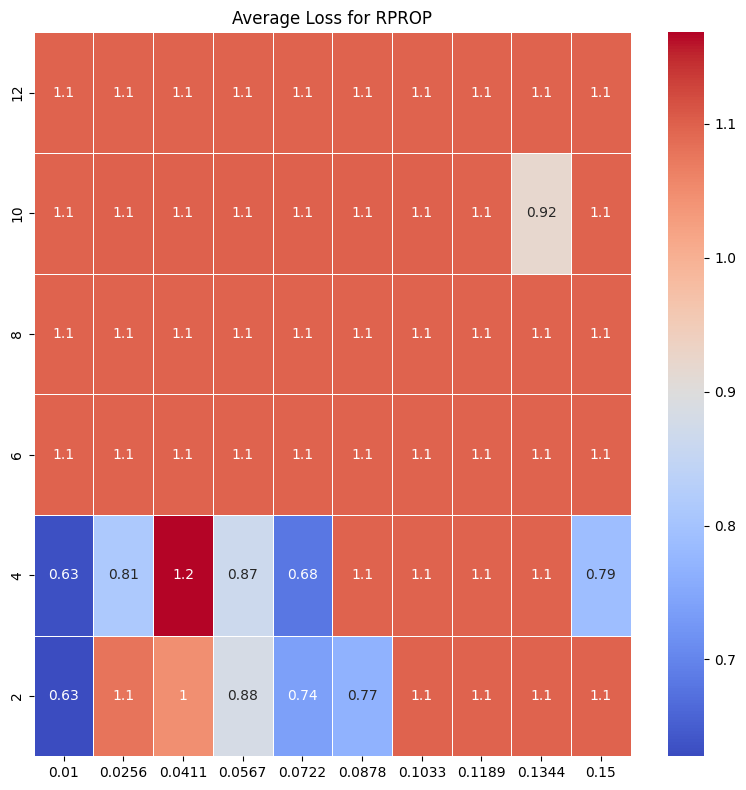

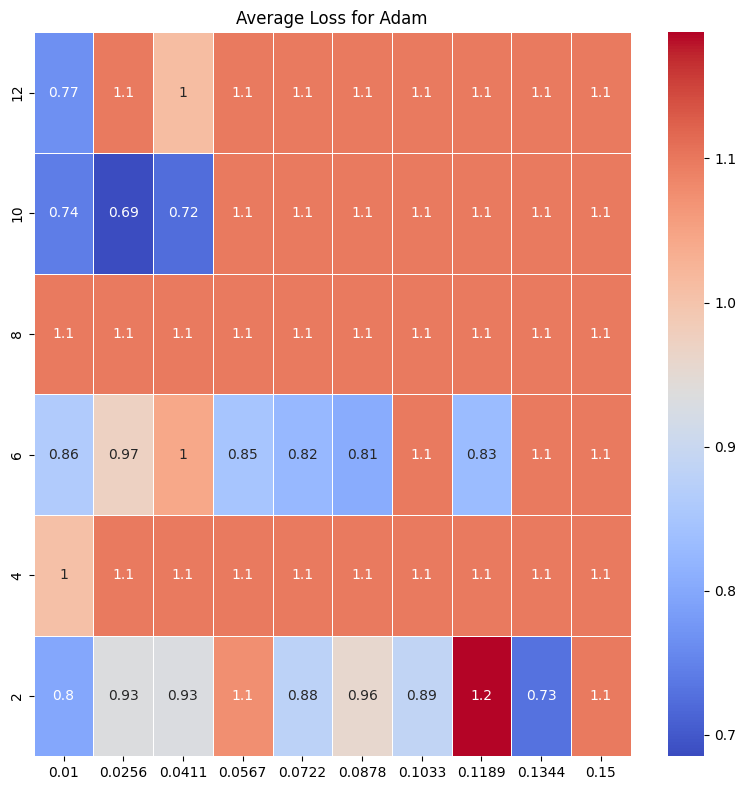

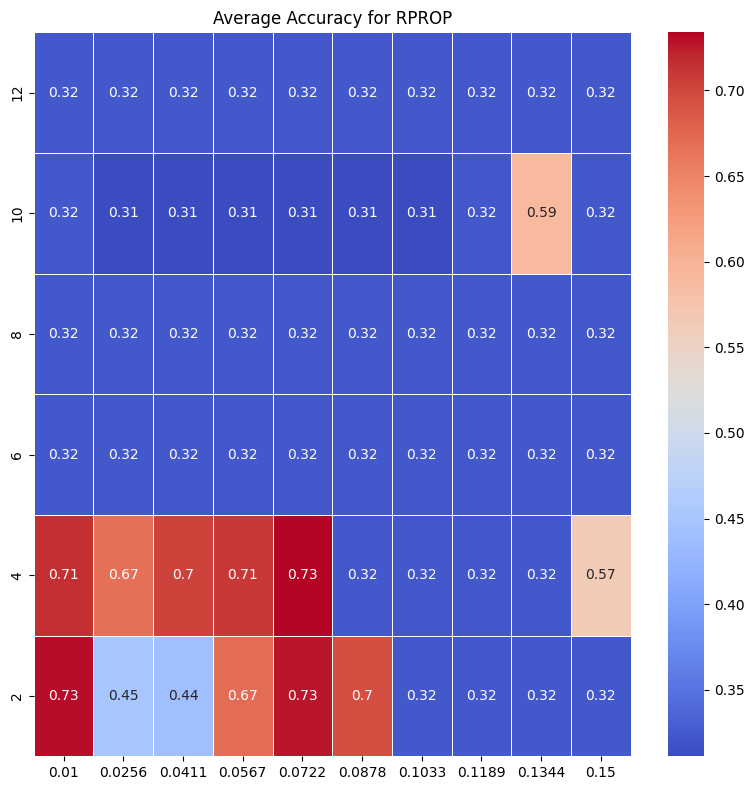

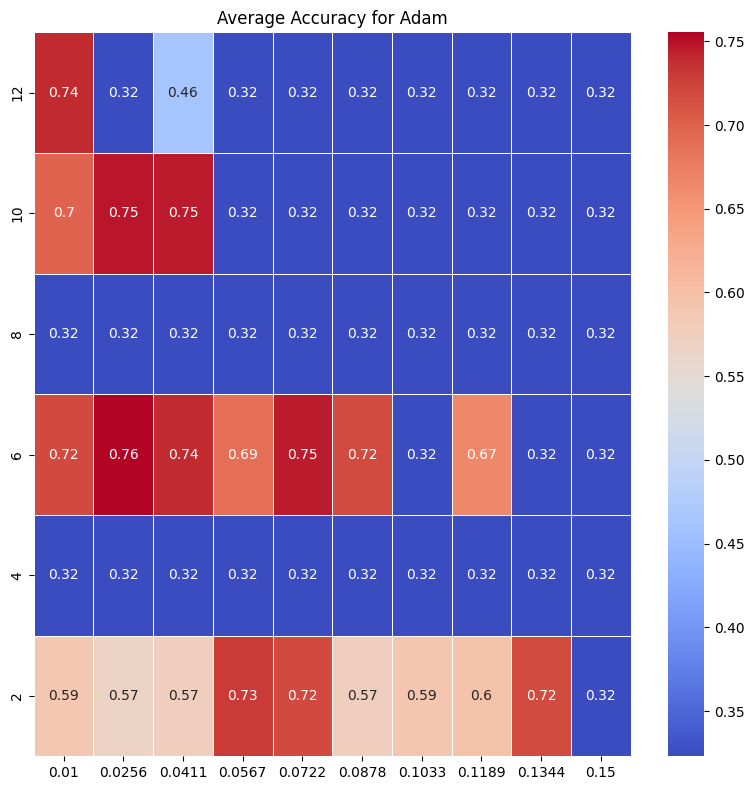

Best hyperparameters for RPROP:  (3, 0.0411)
Best hyperparameters for Adam:  (8, 0.0256)
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Average accuracy:  tensor(0.6112)
Average precision:  tensor(0.6115)
Average recall:  tensor(0.5316)
Average F1 score:  tensor(0.5499)
Standard deviation of accuracy:  tensor(0.1716)
Standard deviation of precision:  tensor(0.1690)
Standard deviation of recall:  tensor(0.2664)
Standard deviation of F1 score:  tensor(0.2404)
Best run seed for RPROP:  1727861035  with accuracy:  tensor(0.7743)  and F1 score:  tensor(0.7780)
Average accuracy:  tensor(0.4366)
Average precision:  tensor(0.4456)
Average recall:  tensor(0.2758)
Average F1 score:  tensor(0.3144)
Standard deviation of accuracy:  tensor(0.1558)
Standard deviation of precision:  tensor(0.1502)
Standard deviation of recall:  tensor(0.2302)
Standard deviation of F1 score:  tensor(0.2081)
Best run seed for Adam:  1727861618  with accuracy:  tensor(0.7197)  and F1 score:  tensor(0.7176)

In [86]:
epochs = 1000

best_hyper_loss_RPROP, best_hyper_loss_SGD, best_hyper_acc_RPROP, best_hyper_acc_SGD = hyper_param_op()

best_hyper_RPROP = (int((best_hyper_loss_RPROP[0] + best_hyper_acc_RPROP[0]) / 2), (best_hyper_loss_RPROP[1] + best_hyper_acc_RPROP[1]) / 2)
best_hyper_SGD = (int((best_hyper_loss_SGD[0] + best_hyper_acc_SGD[0]) / 2), (best_hyper_loss_SGD[1] + best_hyper_acc_SGD[1]) / 2)

print("Best hyperparameters for RPROP: ", best_hyper_RPROP)
print("Best hyperparameters for Adam: ", best_hyper_SGD)


epochs = 5000

accuracy_array_RPROP = []
precision_array_RPROP = []
recall_array_RPROP = []
f1_array_RPROP = []

accuracy_array_Adam = []
precision_array_Adam = []
recall_array_Adam = []
f1_array_Adam = []

best_run_seed_RPROP = None
best_run_acc_RPROP = None
best_run_f1_RPROP = None

best_run_seed_Adam = None
best_run_acc_Adam = None
best_run_f1_Adam = None

for i in range(10):
  print(f"Run {i + 1}")
  seed = round(time.time())
  learning_rate = best_hyper_RPROP[1]
  num_hidden_layers = best_hyper_RPROP[0]
  accuracy, precision, recall, f1 = RPROP_run()
  accuracy_array_RPROP.append(accuracy)
  precision_array_RPROP.append(precision)
  recall_array_RPROP.append(recall)
  f1_array_RPROP.append(f1)

  if best_run_seed_RPROP is None or (accuracy > best_run_acc_RPROP and f1 > best_run_f1_RPROP):
    best_run_seed_RPROP = seed
    best_run_acc_RPROP = accuracy
    best_run_f1_RPROP = f1

  learning_rate = best_hyper_SGD[1]
  num_hidden_layers = best_hyper_SGD[0]
  accuracy, precision, recall, f1 = Adam_run()
  accuracy_array_Adam.append(accuracy)
  precision_array_Adam.append(precision)
  recall_array_Adam.append(recall)
  f1_array_Adam.append(f1)

  if best_run_seed_Adam is None or (accuracy > best_run_acc_Adam and f1 > best_run_f1_Adam):
    best_run_seed_Adam = seed
    best_run_acc_Adam = accuracy
    best_run_f1_Adam = f1


accuracy_array = torch.tensor(accuracy_array_RPROP)
precision_array = torch.tensor(precision_array_RPROP)
recall_array = torch.tensor(recall_array_RPROP)
f1_array = torch.tensor(f1_array_RPROP)

accuracy_avg = torch.mean(accuracy_array, dim=0)
precision_avg = torch.mean(precision_array, dim=0)
recall_avg = torch.mean(recall_array, dim=0)
f1_avg = torch.mean(f1_array, dim=0)

print("Average accuracy: ", accuracy_avg)
print("Average precision: ", precision_avg)
print("Average recall: ", recall_avg)
print("Average F1 score: ", f1_avg)

accuracy_std = torch.std(accuracy_array, dim=0)
precision_std = torch.std(precision_array, dim=0)
recall_std = torch.std(recall_array, dim=0)
f1_std = torch.std(f1_array, dim=0)

print("Standard deviation of accuracy: ", accuracy_std)
print("Standard deviation of precision: ", precision_std)
print("Standard deviation of recall: ", recall_std)
print("Standard deviation of F1 score: ", f1_std)

print("Best run seed for RPROP: ", best_run_seed_RPROP, " with accuracy: ", best_run_acc_RPROP, " and F1 score: ", best_run_f1_RPROP)

accuracy_array = torch.tensor(accuracy_array_Adam)
precision_array = torch.tensor(precision_array_Adam)
recall_array = torch.tensor(recall_array_Adam)
f1_array = torch.tensor(f1_array_Adam)

accuracy_avg = torch.mean(accuracy_array, dim=0)
precision_avg = torch.mean(precision_array, dim=0)
recall_avg = torch.mean(recall_array, dim=0)
f1_avg = torch.mean(f1_array, dim=0)

print("Average accuracy: ", accuracy_avg)
print("Average precision: ", precision_avg)
print("Average recall: ", recall_avg)
print("Average F1 score: ", f1_avg)

accuracy_std = torch.std(accuracy_array, dim=0)
precision_std = torch.std(precision_array, dim=0)
recall_std = torch.std(recall_array, dim=0)
f1_std = torch.std(f1_array, dim=0)

print("Standard deviation of accuracy: ", accuracy_std)
print("Standard deviation of precision: ", precision_std)
print("Standard deviation of recall: ", recall_std)
print("Standard deviation of F1 score: ", f1_std)

print("Best run seed for Adam: ", best_run_seed_Adam, " with accuracy: ", best_run_acc_Adam, " and F1 score: ", best_run_f1_Adam)


# Hybrid learning

In [88]:
learning_rate_1 = best_hyper_RPROP[1]
learning_rate_2 = best_hyper_SGD[1]

num_hidden_1 = best_hyper_RPROP[0]
num_hidden_2 = best_hyper_SGD[0]

acc_array = []
precision_array = []
recall_array = []
f1_array = []

best_run_seed = None
best_run_acc = None
best_run_f1 = None


data = perform_preprocessing() # type: ignore
X_train, X_test, y_train, y_test = split_data()

for run in range(10):
    seed = round(time.time())

    classifier = NNModel(seed=seed, num_hidden_layers=num_hidden_1) 

    criterion = nn.CrossEntropyLoss()
    optimiser_RPROP = torch.optim.Rprop(classifier.parameters(), lr=learning_rate_1)
    optimiser_Adam = torch.optim.Adam(classifier.parameters(), lr=learning_rate_2)

    for epoch in range(epochs):
        indices = torch.randperm(X_train.shape[0])
        X_train = X_train[indices]
        y_train = y_train[indices]

        y_pred = classifier.forward(X_train)

        loss = criterion(y_pred, y_train)

        optimiser_RPROP.zero_grad()
        optimiser_Adam.zero_grad()

        loss.backward()

        for param in classifier.parameters():
            if param.grad is not None:
                rprop_grad = param.grad.clone()
                Adam_grad = param.grad.clone()

                avg_grad = (rprop_grad + Adam_grad) / 2

                param.grad.copy_(avg_grad)

        optimiser_RPROP.step()
        optimiser_Adam.step()

        if epoch % 100 == 0:
            with torch.no_grad():
                confusion_matrix = torch.zeros(3, 3)
                y_val = classifier.forward(X_train)
                y_val = torch.argmax(y_val, dim=1)
                for i in range(len(y_val)):
                    confusion_matrix[y_val[i], y_train[i]] += 1
                accuracy, precision, recall, fscore = calculate_metrics(confusion_matrix)

    # Test the model after training
    with torch.no_grad():
        confusion_matrix = torch.zeros(3, 3)
        y_test_pred = classifier.forward(X_test)
        y_test_pred = torch.argmax(y_test_pred, dim=1)
        for i in range(len(y_test_pred)):
            confusion_matrix[y_test_pred[i], y_test[i]] += 1
        
        accuracy, precision, recall, fscore = calculate_metrics(confusion_matrix)
        print(f'Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {fscore:.4f}')
        acc_array.append(accuracy)
        precision_array.append(precision)
        recall_array.append(recall)
        f1_array.append(fscore)

        if best_run_seed is None or (accuracy > best_run_acc and fscore > best_run_f1):
            best_run_seed = seed
            best_run_acc = accuracy
            best_run_f1 = fscore


# create a table with the averages of the metrics
accuracy_array = torch.tensor(acc_array)
precision_array = torch.tensor(precision_array)
recall_array = torch.tensor(recall_array)
f1_array = torch.tensor(f1_array)

accuracy_avg = torch.mean(accuracy_array, dim=0)
precision_avg = torch.mean(precision_array, dim=0)
recall_avg = torch.mean(recall_array, dim=0)
f1_avg = torch.mean(f1_array, dim=0)

print("Average accuracy: ", accuracy_avg)
print("Average precision: ", precision_avg)
print("Average recall: ", recall_avg)
print("Average F1 score: ", f1_avg)

# create a table with the standard deviations of the metrics
accuracy_std = torch.std(accuracy_array, dim=0)
precision_std = torch.std(precision_array, dim=0)
recall_std = torch.std(recall_array, dim=0)
f1_std = torch.std(f1_array, dim=0)

print("Standard deviation of accuracy: ", accuracy_std)
print("Standard deviation of precision: ", precision_std)
print("Standard deviation of recall: ", recall_std)
print("Standard deviation of F1 score: ", f1_std)

print("Best run seed for RPROP: ", best_run_seed, " with accuracy: ", best_run_acc, " and F1 score: ", best_run_f1)


C:\Users\robof\AppData\Local\Temp\ipykernel_12508\4038975902.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)


Test Accuracy: 0.3278, Precision: 0.3333, Recall: 0.1093, F1 Score: 0.1646
Test Accuracy: 0.7458, Precision: 0.7465, Recall: 0.7565, F1 Score: 0.7475
Test Accuracy: 0.5392, Precision: 0.5437, Recall: 0.4588, F1 Score: 0.4517
Test Accuracy: 0.7648, Precision: 0.7646, Recall: 0.7655, F1 Score: 0.7650
Test Accuracy: 0.5487, Precision: 0.5531, Recall: 0.4556, F1 Score: 0.4590
Test Accuracy: 0.3278, Precision: 0.3333, Recall: 0.1093, F1 Score: 0.1646
Test Accuracy: 0.3278, Precision: 0.3333, Recall: 0.1093, F1 Score: 0.1646
Test Accuracy: 0.7577, Precision: 0.7579, Recall: 0.7644, F1 Score: 0.7594
Test Accuracy: 0.3278, Precision: 0.3333, Recall: 0.1093, F1 Score: 0.1646
Test Accuracy: 0.3278, Precision: 0.3333, Recall: 0.1093, F1 Score: 0.1646
Average accuracy:  tensor(0.4995)
Average precision:  tensor(0.5032)
Average recall:  tensor(0.3747)
Average F1 score:  tensor(0.4006)
Standard deviation of accuracy:  tensor(0.1970)
Standard deviation of precision:  tensor(0.1946)
Standard deviation